In [1]:
%matplotlib inline


import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import PorterStemmer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity
import re
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import pickle

# https://github.com/prestonlam53/building_job_recommender_3


# Lets have a detailed look at the job.csv file

In [2]:
df=pd.read_csv('jobs.csv')


df.head()


,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,keyword
0,0,"['principal', 'ux', 'designer', 'physical', 'p...",$159K-$299K (Glassdoor est.),At Sonos we want to create the ultimate listen...,4.1,"Sonos, Inc.\n4.1","San Francisco, CA",-1,1001 to 5000 Employees,2002,Company - Public,Consumer Products Manufacturing,Manufacturing,$500 million to $1 billion (USD),-1,"ux,designer"
1,1,"['ux', 'ui', 'designer']",$159K-$299K (Glassdoor est.),#TeamNextdoor\n\n\nNextdoor is the neighborhoo...,4.1,Nextdoor\n4.1,"San Francisco, CA",-1,201 to 500 Employees,2010,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,-1,"ux,designer"
2,2,"['ui', 'ux', 'architect', 'designer']",$159K-$299K (Glassdoor est.),Description: *\nSPODIO is a data-driven sports...,-1.0,Spodio Group,"San Francisco, CA",-1,1 to 50 Employees,-1,Company - Private,-1,-1,Less than $1 million (USD),-1,"ux,designer"
3,3,"['freelance', 'ui', 'ux', 'designer']",$159K-$299K (Glassdoor est.),SUMMARY OF POSITION\n\nThe UI/UX Designer is a...,3.6,On Board Entertainmet\n3.6,"San Francisco, CA",-1,51 to 200 Employees,1995,Company - Private,Advertising & Marketing,Business Services,$50 to $100 million (USD),-1,"ux,designer"
4,4,"['jr', 'ux', 'designer']",$159K-$299K (Glassdoor est.),"WHO WE ARE:\n\nFounded in 2012, BirdEye is hea...",4.5,BirdEye\n4.5,"Palo Alto, CA",-1,201 to 500 Employees,2012,Company - Private,Internet,Information Technology,$25 to $50 million (USD),-1,"ux,designer"


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         208 non-null    int64  
 1   Job Title          208 non-null    object 
 2   Salary Estimate    208 non-null    object 
 3   Job Description    208 non-null    object 
 4   Rating             208 non-null    float64
 5   Company Name       208 non-null    object 
 6   Location           208 non-null    object 
 7   Headquarters       208 non-null    int64  
 8   Size               208 non-null    object 
 9   Founded            208 non-null    int64  
 10  Type of ownership  208 non-null    object 
 11  Industry           208 non-null    object 
 12  Sector             208 non-null    object 
 13  Revenue            208 non-null    object 
 14  Competitors        208 non-null    int64  
 15  keyword            208 non-null    object 
dtypes: float64(1), int64(4), o

In [4]:
#printing column 3 "Job Description" of a random row 200 
df.iloc[0,3]


'At Sonos we want to create the ultimate listening experience for our customers and know that it starts by listening to each other. As part of the Sonos team, youll collaborate with people of all styles, skill sets, and backgrounds to realize our vision while fostering a community where everyone feels included and empowered to do to the best work of their lives.\n\nSonos is looking for a Principal UX Designer to join our Core Platform UX team. In this role, you will work as a critical part of the team that delivers a secure, connected and immersive sound platform to enable innovative listening experiences on Sonos Hardware. Driving and executing against the roadmap and company strategy, you will work closely with partners across hardware and software to bring new products and sound experiences to market.* Embrace the system: Go deep to understand the technical landscape of the Sonos system and identify opportunities to deliver the best experience possible in leveraging and extending th

In [5]:
#printing job name (keyword) of the above job description
df.iloc[0,15]
# df.loc[df['keyword']=='data,scientist']['Job Description']


'ux,designer'

### lets find out the number of different job fields present in given 208 entries

In [6]:
print("any resume will be matched to jobs in any of the following 9 fileds")
print("********************************************************************")
print(pd.unique(df['keyword']))


any resume will be matched to jobs in any of the following 9 fileds
********************************************************************
['ux,designer' 'data,scientist' 'data,analyst' 'project,manager'
 'product,manager' 'account,manager' 'consultant' 'marketing' 'sales']


In [7]:
Label_wise_job = df.groupby(['keyword']).size().reset_index(name='Label_wise').sort_values('Label_wise',
                                                                             ascending=False)

print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.2.2


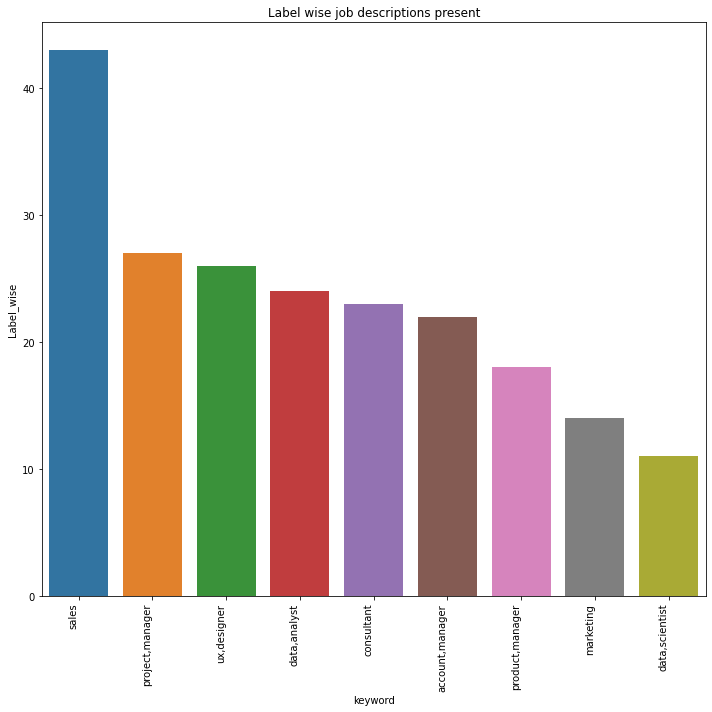

In [8]:
plt.figure(figsize=(10,10))
ax = sns.barplot(x="keyword", y="Label_wise", data=Label_wise_job)
sns.set_style("whitegrid")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('Label wise job descriptions present')
# ax.bar_label(ax.containers[0])

# for index, row in Label_wise_job.iterrows():
#     ax.text(row.name,row.tip, round(row.total_bill,2), color='black', ha="center")
plt.tight_layout()
plt.show()

# we'll go through following procedure
1. we will be working on on "Job Description " and " keyword"  column <br>
2. job description will work as our X_data and keyword will work as label i.e Y_data <br>
3. Data Cleaning and Topic Modelling:<br>
    a)converting X_data which is in string form to a vector (form document,word matrix) <br>
    b)then perform topic modelling ( which is like clustering 208 different documents into 8 clusters for 8 different job fields)<br>
3. now our job is to apply a classification algorithm on any input resume information 
   and classify it as one of the 9 Job labels.


## 1. we will be working on on "Job Description " and " keyword" column

In [9]:
#1. we will be working on on "Job Description " and " keyword" column
jobs_df = pd.DataFrame(zip(df['Job Description'], df['keyword']), columns = ['Description', 'Job'])
jobs_df    

,Description,Job
0,At Sonos we want to create the ultimate listen...,"ux,designer"
1,#TeamNextdoor\n\n\nNextdoor is the neighborhoo...,"ux,designer"
2,Description: *\nSPODIO is a data-driven sports...,"ux,designer"
3,SUMMARY OF POSITION\n\nThe UI/UX Designer is a...,"ux,designer"
4,"WHO WE ARE:\n\nFounded in 2012, BirdEye is hea...","ux,designer"
...,...,...
203,"As a Pella Outside Sales Professional, you wil...",sales
204,We would be nothing without our successful sal...,sales
205,Job Description: Sales Support Agent*\n(Intern...,sales
206,Be Part of our Culture*\nIf you are ready for ...,sales


## 2. job description will work as our X_data and keyword will work as label i.e Y_data

In [10]:


X_data,Y_data = jobs_df.iloc[:,0:-1], jobs_df.iloc[:, -1]
X_train, X_test, Y_train, Y_test = train_test_split(X_data,Y_data)


## 3. Data Cleaning and Topic Modelling:converting X_data which is in string form to a vector

### function to tokenize a string

In [11]:
def tokenize_stem(df):

    tokenizer =TreebankWordTokenizer()
    stemmer = PorterStemmer()
    df = df.apply(lambda x: x.replace("\n", ' '))
    df = df.apply(lambda x: tokenizer.tokenize(x))
    df = df.apply(lambda x: [stemmer.stem(w) for w in x])
    df = df.apply(lambda x: ' '.join(x))
    return df

### Function to display top N=10 words per topic

In [12]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    '''
    displays topics and returns list of toppics
    '''

    topic_list = []
    for topic, words in enumerate(model.components_):
     
#         print("\nTopic ", topic, " top ",no_top_words, " features are :")
#         print(", ".join([feature_names[k]
#                        for k in words.argsort()[:-no_top_words - 1:-1]]))
        topic_list.append(", ".join([feature_names[k]
                       for k in words.argsort()[:-no_top_words - 1:-1]]))
    return  topic_list

### Converting 208 job Description to document-term matrix using vectorizer=Tfidf

In [13]:
def convert_into_vector(df,vectorizer=TfidfVectorizer):
    
      #turn job into series
       
    series = tokenize_stem(df)
    
    vec = vectorizer(stop_words = 'english')
    doc_word = vec.fit_transform(series)
    word_indx=vec.get_feature_names()
    vec_name = 'JOB_VEC.sav'
    pickle.dump(vec, open(vec_name, 'wb'))
      

    
    return doc_word, word_indx   


    
    
    
    

# Topic modelling:

Following is visulaisation of break down document-term matrix into document-topic and topic-word matrix in NMF topic Modelling
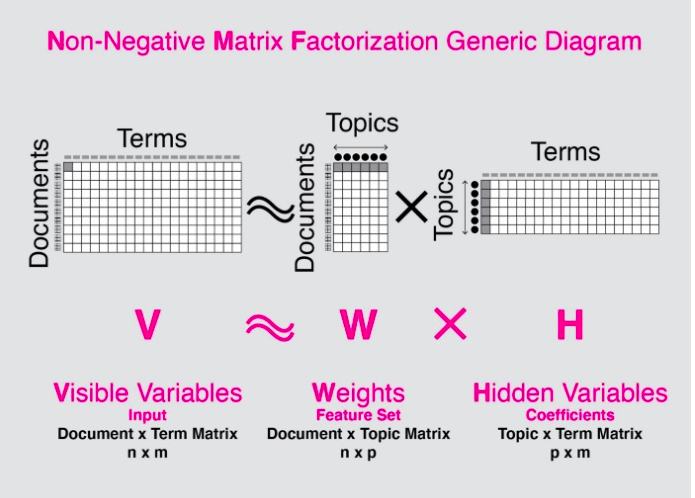

In [14]:
def topic_modelling(doc_word,word_indx, num_topics, num_top_words, model=TruncatedSVD):
    
    
    topic_model = model(num_topics)
    topic_model = topic_model.fit(doc_word)
    doc_topic = topic_model.transform(doc_word)
    topic_model_name = 'TOPIC_MODEL.sav'
    pickle.dump(topic_model, open(topic_model_name, 'wb'))
    
   
    topic_list = display_topics(topic_model, word_indx, num_top_words)

    topic_df=pd.DataFrame(doc_topic)
    topic_df.columns = ['topic ' + str(i+1) for i in range(len(topic_df.columns)) ]
    topic_df['job'] = jobs_df.Job
#     topic_df.to_csv('TOPIC_DF.csv')
    return  topic_df

    
    
    
    

# 4. Finally apply a classification algorithm to classify any input resume into one of the 9 Job labels.

In [15]:

def predictive_modeling(df):
    '''
    fits, optimizes, and predicts job class based on topic modeling corpus
    '''
    X,y = df.iloc[:,0:-1], df.iloc[:, -1]
    X_tr, X_te, y_tr, y_te = train_test_split(X,y)

    param_grid = {'n_estimators': [100,300, 400, 500, 600], 'max_depth': [3,7,9, 11]}
    # search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
    # search.fit(X_tr, y_tr)
    # bp = search.best_params_
    # print(bp)
    #rfc = RandomForestClassifier(n_estimators = bp['n_estimators'], max_depth = bp['max_depth'])
    rfc = RandomForestClassifier(n_estimators = 500, max_depth = 9)
    rfc.fit(X_tr, y_tr)
    print('acc: ', np.mean(cross_val_score(rfc, X_tr, y_tr, scoring = 'accuracy', cv=5)))
    print('test_acc: ', accuracy_score(y_te, rfc.predict(X_te)))
    print(rfc.predict(X_te))
    
    classifier_name = 'CLASSIFICATION_MODEL.sav'
    pickle.dump(rfc, open(classifier_name, 'wb'))
    return rfc

## Run this Function to generate all the CSV files require to classify resumes. 

In [16]:
def get_topic_classification_models():
    doc_word, word_indx=convert_into_vector(jobs_df['Description'],TfidfVectorizer)
    
    #topic_df will contain 20 topic  of each document (its an array of num_of_doc x num_of_topic dim)
    topic_df=topic_modelling(doc_word,word_indx,20, 10, TruncatedSVD)
    
    classification_model = predictive_modeling(topic_df) #here topic df is after reducig num of words
    return


In [17]:
#get_topic_classification_models()


# function to predic Resume classification on already generated models

In [18]:
def predict_resume(topic_model, model, resume):
    '''
    transforms a resume based on the topic modeling model and return prediction probabilities per each job class
    '''
    doc = topic_model.transform(resume)
    return model.predict_proba(doc), model.classes_

# function call for resume matching

In [19]:
def main_fun(resume, topic_model, predictor, vec):
    '''
    run code that predicts resume
    '''
    #jobs_df, model, vec , topic_list= process_data()
    #model_1 = predictive_modeling(jobs_df)

    doc = tokenize_stem(resume)
    doc = vec.transform(doc)
    probabilities, classes = predict_resume(topic_model, predictor, doc)
    return classes, probabilities[0]*100


In [20]:
def autopct_generator(limit):
            """Remove percent on small slices."""
            def inner_autopct(pct):
                return ('%.2f%%' % pct) if pct > limit else ''
            return inner_autopct
def plot(data):

        

        labels = data['jobs']
        sizes =data['probability']
        NUM_COLORS = len(sizes)

        fig1, ax1 = plt.subplots(figsize=(10, 10))

        # set color theme
        # https://matplotlib.org/api/pyplot_summary.html#colors-in-matplotlib
        theme = plt.get_cmap('bwr')
        ax1.set_prop_cycle(color=[theme(
            1. * i / NUM_COLORS) for i in range(NUM_COLORS)])

        box = ax1.get_position()
        ax1.set_position([box.x0, box.y0, box.width * 1.3, box.height])

        _, _, autotexts = ax1.pie(
            sizes, autopct=autopct_generator(7), startangle=90, radius=1.8 * 1000)
        for autotext in autotexts:
            autotext.set_weight('bold')
        ax1.axis('equal')
        total = sum(sizes)
        plt.legend(
            loc='upper left',
            labels=['%s, %1.1f%%' % (
                l, (float(s) / total) * 100) for l, s in zip(labels, sizes)],
            prop={'size': 12},
            bbox_to_anchor=(0.0, 1),
            bbox_transform=fig1.transFigure
        )
        # fig1.set_size_inches(18.5, 10.5)
        fig1.savefig('chart.png')

# insert resume and get to what job your resume match the most

In [28]:
def process_resume(resume):
    
    resume = re.sub('[^a-zA-Z0-9\.]', ' ', resume)
    resume = resume.lower()

    resume = pd.Series(resume)

    #load NLP + classification models

    topic_model = pickle.load(open('TOPIC_MODEL.sav', 'rb'))
    classifier = pickle.load(open('CLASSIFICATION_MODEL.sav', 'rb'))
    vec = pickle.load(open('JOB_VEC.sav', 'rb'))

    classes, prob = main_fun(resume, topic_model, classifier, vec)
    probabilities=prob
    data = pd.DataFrame(zip(classes.T, probabilities.T), columns = ['jobs', 'probability'])

    plot(data)


    

In [31]:
df.iloc[20,3]
#df.iloc[20,15]

'ux,designer'

In [29]:
val = input("emter")#X_data.iloc[0]




emter'At Sonos we want to create the ultimate listening experience for our customers and know that it starts by listening to each other. As part of the Sonos team, youll collaborate with people of all styles, skill sets, and backgrounds to realize our vision while fostering a community where everyone feels included and empowered to do to the best work of their lives.\n\nSonos is looking for a Principal UX Designer to join our Core Platform UX team. In this role, you will work as a critical part of the team that delivers a secure, connected and immersive sound platform to enable innovative listening experiences on Sonos Hardware. Driving and executing against the roadmap and company strategy, you will work closely with partners across hardware and software to bring new products and sound experiences to market.* Embrace the system: Go deep to understand the technical landscape of the Sonos system and identify opportunities to deliver the best experience possible in leveraging and extendi

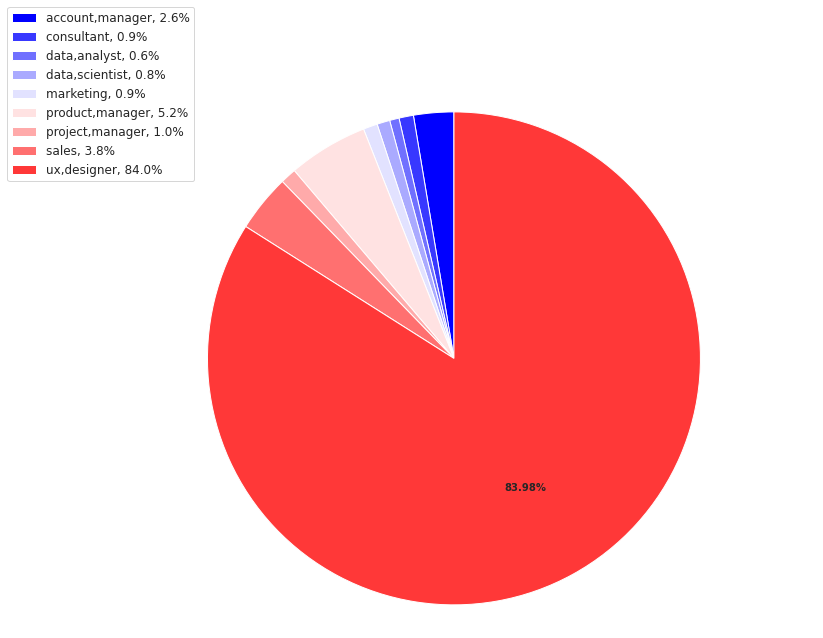

In [30]:
process_resume(val)

In [22]:


#load NLP + classification models

topic_model = pickle.load(open('TOPIC_MODEL.sav', 'rb'))
classifier = pickle.load(open('CLASSIFICATION_MODEL.sav', 'rb'))
vec = pickle.load(open('JOB_VEC.sav', 'rb'))

# classes, prob = main_fun(user_input, topic_model, classifier, vec)

doc = tokenize_stem(resume)
doc = vec.transform(doc)


doc = topic_model.transform(doc)
probabilities, classes =  classifier.predict_proba(doc)[0]*100, classifier.classes_
print(probabilities)
print(classes)



data = pd.DataFrame(zip(classes.T, probabilities.T), columns = ['jobs', 'probability'])

[ 2.63300366  0.94690476  0.62142857  0.845       0.93111111  5.2378022
  1.04444444  3.75634921 83.98395604]
['account,manager' 'consultant' 'data,analyst' 'data,scientist'
 'marketing' 'product,manager' 'project,manager' 'sales' 'ux,designer']


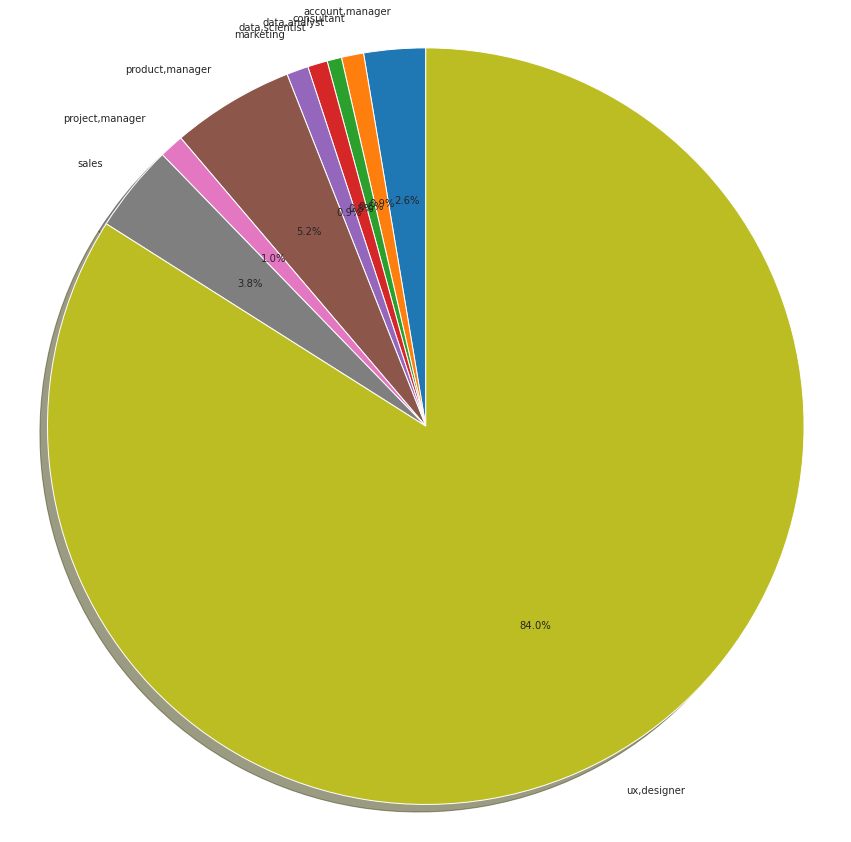

In [34]:
def plot_user_probability():
 
    labels = data['jobs']
    sizes = data['probability']
    fig1, ax1 = plt.subplots(figsize=(15, 15))
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()
    return

plot_user_probability()

In [39]:
def autopct_generator(limit):
            """Remove percent on small slices."""
            def inner_autopct(pct):
                return ('%.2f%%' % pct) if pct > limit else ''
            return inner_autopct
def plot():

        

        labels = data['jobs']
        sizes =data['probability']
        NUM_COLORS = len(sizes)

        fig1, ax1 = plt.subplots(figsize=(10, 10))

        # set color theme
        # https://matplotlib.org/api/pyplot_summary.html#colors-in-matplotlib
        theme = plt.get_cmap('bwr')
        ax1.set_prop_cycle(color=[theme(
            1. * i / NUM_COLORS) for i in range(NUM_COLORS)])

        box = ax1.get_position()
        ax1.set_position([box.x0, box.y0, box.width * 1.3, box.height])

        _, _, autotexts = ax1.pie(
            sizes, autopct=autopct_generator(7), startangle=90, radius=1.8 * 1000)
        for autotext in autotexts:
            autotext.set_weight('bold')
        ax1.axis('equal')
        total = sum(sizes)
        plt.legend(
            loc='upper left',
            labels=['%s, %1.1f%%' % (
                l, (float(s) / total) * 100) for l, s in zip(labels, sizes)],
            prop={'size': 12},
            bbox_to_anchor=(0.0, 1),
            bbox_transform=fig1.transFigure
        )
        # fig1.set_size_inches(18.5, 10.5)
        fig1.savefig('chart.png')

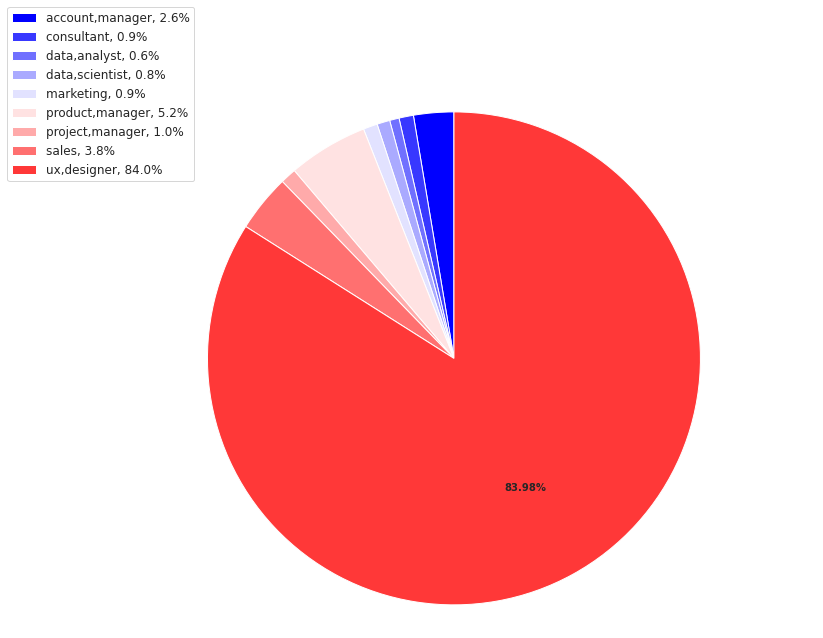

In [40]:
plot()